<h1 align='center'><b><font color='indianred'></p>Spam Detection HW</b></h1>

<font color = 'indianred' size = 4 >**Read complete instructions before starting the HW** </font>


# <font color='indianred'> **Q1: Load the dataset  (1 Point)**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe. 

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





#### <font color='ember'>Connect to Drive

In [1]:
import sys
from pathlib import Path
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  !pip install -U nltk -qq
  !pip install -U spacy -qq
  !python -m spacy download en_core_web_sm -qq

  # Import the drive module from google.colab
  # Mount Google Drive to access files and directories
  from google.colab import drive  
  drive.mount('/content/drive')
  # Set the basepath to the data directory in Google Drive
  base_folder = Path('/content/drive/MyDrive/colab_notebooks')
  subject = 'nlp'
  data = base_folder/subject/'data/'
  archive = base_folder/subject/'archive/'
  output = base_folder/subject/'output'
  model_folder = base_folder/subject/'models/HW3'
  custom_functions = base_folder/subject/'custom_functions'
  # Add the path to the custom-functions directory in Google Drive to sys.path
  sys.path.append('/content/drive/MyDrive/colab_notebooks/nlp/custom_functions')
else:
  print('Not Running on Colab')
  # Add the path to the custom-functions directory in the local file system to sys.path
  sys.path.append('C:/Users/Abdul Rauf Maroof/OneDrive/Documents/MSBA/custom_functions')
  base_folder = Path('C:/Users/Abdul Rauf Maroof/OneDrive/Documents/MSBA')
  data = base_folder/'data/'
  archive = base_folder/'archive/'
  output = base_folder/'output'
  custom_functions = base_folder/'custom_functions'

Not Running on Colab


#### <font color = 'ember'>Import Library

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
from featurizer import ManualFeatures

In [4]:
# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [5]:
import custom_preprocessor_mod as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve

#### <font color='ember'> Unzip File

In [6]:
for entry in archive.iterdir():
  if 'zip' in entry.name:
    print(entry.name)

my_spotify_data.zip
Spotify-20230303T164824Z-001.zip


In [ ]:
file = archive/'SMS_spam.zip'

In [ ]:
with zipfile.ZipFile(file,'r') as f:
  print(f.namelist())

['spam.csv']


In [ ]:
with zipfile.ZipFile(file, 'r') as f:
  f.extract('spam.csv', path = data)

In [ ]:
file_csv = data/'spam.csv'
!head -n 5 {str(file_csv)}

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,


#### <font color='ember'>Cleaning Dataframe and Checking Data

In [ ]:
df = pd.read_csv(file_csv, encoding = 'ISO-8859-1')
df = df.iloc[:,:2]
df = df.rename({'v1':'label','v2':'message'}, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df2 = df.groupby('label').count(); df2.reset_index(inplace=True)
df2['percent'] = round((df2['message'] / 
                  df2['message'].sum()) * 100, 2)
df2

,label,message,percent
0,ham,4825,86.59
1,spam,747,13.41


##### <font Color = 'ember'> Based on the dataframe we can see that ham is 86.59%  while spam is 13.41% 

In [ ]:
# For the purpose of this assignment we assume spam is positive and ham is negative given that this is a spam detection model.
df.label = df.label.replace({'ham':0,'spam':1})

# <font color='indianred'> **Q2 : Provide the metric for evaluating model (1 Point)**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

#### <font color = 'ember'> Some alternative metrics we can use in substitute of accuracy for an imbalanced dataset are as follows:

1. **Recall** is the ratio of true positive predictions to the total number of actual positive instances. The formula would be as follows: $\frac{TP}{TP+FN}$ this measure is useful when false negatives are costly so it may not be appropriate in this case. 

2. **Precision** is the ratio of true positive predictions to the total number of positive predictions. The formula would be as follows: $\frac{TP}{TP+FP}$ this measure would be better suited in this case as there is a hiigh number of positive instances. 

3. **F1-score** is the harmonic mean of precision and recall. It is a useful metric when both false negatives and false positives are equally important. F1 score is often used in imbalanced datasets. For the formula for the F1 score is:
$2*\frac{(precision * recall)}{(precision + recall)}$

4. **ROC Curve** and AOC is a graphical representation of the true positive rate (TPR) against the false positive rate (FPR) and the AUC (area under the ROC curve) is a measure of the classifier's performance. It is useful for evaluating models that predict probabilities so in this case it would not be as useful

5. **PR Curve and AUPRC** The PR (precision-recall) curve is a graphical representation of the precision against recall, and the AUPRC (area under the PR curve) is a measure of the classifier's performance. The PR curve is useful for evaluating models that predict probabilities, and is often used in imbalanced datasets where precision and recall are important. It is a good alternative for the ROC Curve when we are working with an imbalanced dataset

6. **Weighted and Macro-Averaged Metrics** are useful when evaluating models on imbalanced datasets, as they give more weight to the minority class and can help ensure that the performance of the model on the minority class is not overlooked. Weighted metrics calculate the average of the metric, weighted by the number of instances in each class, while macro-averaged metrics calculate the average of the metric for each class separately and then take the unweighted average.


For the purpose of our project we will use F1 score with macro averaging as well as precision as these would be better metrics as compared to accuracy given that:

  1. We have an imbalanced dataset that is more weighted towards positive instances therefore a precision would be a better metric as compared to accuracy and recall.
  2. Since we have an imbalanced dataset a F1 score is generally better suited for and using a macro averaged metric would be better as it would give the minority class more weight as compared to weighted approach
  3. For the purpose of my assignment it makes the most sense to use F1 score wiht a macro averaging as the most reliable metric in this case as it gives a harmonic mean of both precision and recall. By using macro weighting we can ensure that we give equal weight in an unbalanced dataset

# <font color='indianred'> **Q3 : Classification Pipelines (18 Points)**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model. 

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:** 

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/). 

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.). 

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn: 

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





#### <font color = 'ember'>Preprocessing

In [ ]:
train_smaller = df.sample(frac=0.1, replace=True, random_state=1)
train_smaller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 5157 to 2195
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    557 non-null    int64 
 1   message  557 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.1+ KB


In [ ]:
X = train_smaller['message'].values
y = train_smaller['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=432)
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (389,) y_train: (389,)
X_test: (168,) y_test: (168,)


In [ ]:
X_train_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(X_train)
# save this to a file
file_X_train_cleaned_sparse_embed = data / 'x_train_cleaned_sparse_embed.pkl'
joblib.dump(X_train_cleaned, file_X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/colab_notebooks/nlp/data/x_train_cleaned_sparse_embed.pkl']

In [ ]:
X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(X_test)
# save  this to a file
file_X_test_cleaned_sparse_embed = data / 'x_test_cleaned_sparse_embed.pkl'
joblib.dump(X_test_cleaned, file_X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/colab_notebooks/nlp/data/x_test_cleaned_sparse_embed.pkl']

### <Font Color = 'skyblue'> Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF)

#### <font color='ember'> Create Pipeline

In [ ]:
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10, ngram_range=(2, 3), lowercase=False, token_pattern=r'\b\w\w+\b')),
    ('classifier', LogisticRegression(max_iter=10000)),
                        ])

#### <font color = 'ember'> Parameter Grid

In [ ]:
param_grid_classifier_1 = {'vectorizer__max_features': [100, 500, 1000, 2000, 5000],
                           'classifier__C': [0.01, 0.05, 0.1, 1, 10, 100, 1000,100000],
                           'classifier__class_weight': [{0:1, 1: cw} for cw in [1,2,10,15,20,25,30]]
                           }

#### <font color='ember'>Specify GridSearch

In [ ]:
grid_classifier_1 = RandomizedSearchCV(estimator=classifier_1,  param_distributions=param_grid_classifier_1, cv = 8, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro')

#### <font color='ember'> Fit the Model

In [ ]:
# Fit the model on training data
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)
grid_classifier_1.fit(X_train_cleaned_sparse_embed, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(lowercase=False,
                                                              max_features=10,
                                                              ngram_range=(2,
                                                                           3),
                                                              token_pattern='\\b\\w\\w+\\b')),
                                             ('classifier',
                                              LogisticRegression(max_iter=10000))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.01, 0.05, 0.1, 1,
                                                          10, 100, 1000,
                                                          100000],
                                        'classifier__class_weight': [{0: 1,
                                    

#### <font color = 'ember'> Get Best Parameters

In [ ]:
print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.67

Best parameters:  {'vectorizer__max_features': 1000, 'classifier__class_weight': {0: 1, 1: 10}, 'classifier__C': 10}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_features=1000,
                                 ngram_range=(2, 3),
                                 token_pattern='\\b\\w\\w+\\b')),
                ('classifier',
                 LogisticRegression(C=10, class_weight={0: 1, 1: 10},
                                    max_iter=10000))])


#### <font color='ember'> Save and Load Model 

In [ ]:
file_best_estimator_pipeline1_round1 = model_folder / 'pipeline1_round1_best_estimator.pkl'
file_complete_grid_pipeline1_round1 = model_folder / 'pipeline1_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_1.best_estimator_, file_best_estimator_pipeline1_round1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1_round1)

['/content/drive/MyDrive/colab_notebooks/nlp/models/HW3/pipeline1_round1_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(file_complete_grid_pipeline1_round1)

#### <font color='ember'> Plot Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

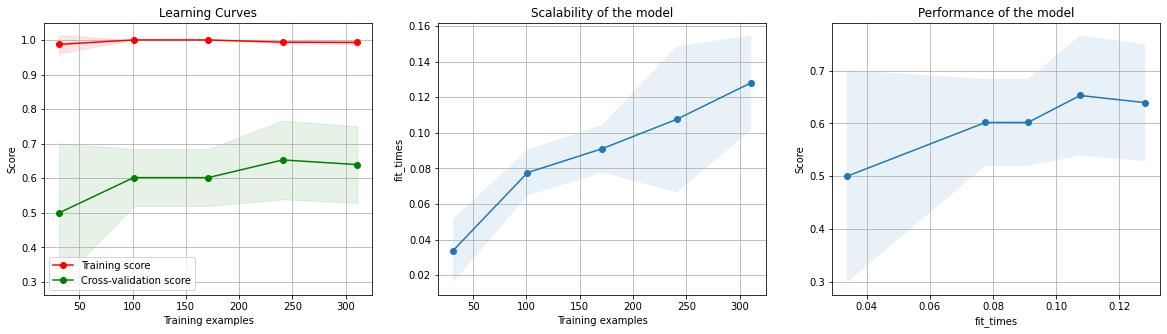

In [ ]:
plot_learning_curve(best_estimator_pipeline1_round1, 'Learning Curves',
                    X_train_cleaned_sparse_embed, y_train, n_jobs=-1,scoring='f1_macro')

#### <font color ='ember'> Check Cross Validation and Train Score

In [ ]:
# let's check the train scores
print(best_estimator_pipeline1_round1.score(X_train_cleaned, y_train))

# let's check the cross validation score
print(complete_grid_pipeline1_round1.best_score_)

0.9974293059125964
0.6745462862399128


#### <font color = 'ember'> Evaluate model on test data

In [ ]:
# Final Pipeline
def final_pipeline(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

#### <font color='ember'> Classification report for test dataset

In [ ]:
print('\nTest set classification report:\n\n', 
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.90      1.00      0.94       145
           1       1.00      0.26      0.41        23

    accuracy                           0.90       168
   macro avg       0.95      0.63      0.68       168
weighted avg       0.91      0.90      0.87       168



### <font color = 'skyblue'>Pipeline 2: Manual Featues with a Machine Learning Model pipeline

#### <font color='ember'> Generate Manual Features

In [ ]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [ ]:
X_train_features, feature_names = featurizer.fit_transform(X_train)

In [ ]:
X_train_features.shape

(389, 11)

In [ ]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

#### <font color='ember'>Create Pipelines

In [ ]:
classifier_2 = Pipeline([
    ('classifier', LogisticRegression(max_iter=10000)),
                        ])

#### <font color='ember'> Parameter Grid

In [ ]:
param_grid_classifier_2 = {'classifier__C': [0.01, 0.05, 0.1, 1, 10, 100, 1000, 10000,100000],
                           'classifier__class_weight': [{0:1, 1: cw} for cw in [1,2,10,15,20,25,30]]}

#### <font color='ember'> Specify GridSearch

In [ ]:
grid_classifier_2 = RandomizedSearchCV(estimator=classifier_2,
                                 param_distributions=param_grid_classifier_2,
                                 cv=8, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro')

#### <font color='ember'> Fit the Model

In [ ]:
# Fit the model on training data
grid_classifier_2.fit(X_train_features, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('classifier',
                                              LogisticRegression(max_iter=10000))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.01, 0.05, 0.1, 1,
                                                          10, 100, 1000, 10000,
                                                          100000],
                                        'classifier__class_weight': [{0: 1,
                                                                      1: 1},
                                                                     {0: 1,
                                                                      1: 2},
                                                                     {0: 1,
                                                                      1: 10},
                                                                     {0: 1,
                                       

#### <font color='ember'> Get the best Parameters

In [ ]:
print(f'Best cross-validation score: {grid_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.97

Best parameters:  {'classifier__class_weight': {0: 1, 1: 2}, 'classifier__C': 1000}

Best estimator:  Pipeline(steps=[('classifier',
                 LogisticRegression(C=1000, class_weight={0: 1, 1: 2},
                                    max_iter=10000))])


#### <font color='ember'> Save and Load Model 

In [ ]:
file_best_estimator_pipeline2_round1 = model_folder / 'pipeline2_round1_best_estimator.pkl'
file_complete_grid_pipeline2_round1 = model_folder / 'pipeline2_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_2.best_estimator_, file_best_estimator_pipeline2_round1)
joblib.dump(grid_classifier_2, file_complete_grid_pipeline2_round1)

['/content/drive/MyDrive/colab_notebooks/nlp/models/HW3/pipeline2_round1_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
complete_grid_pipeline2_round1 = joblib.load(file_complete_grid_pipeline2_round1)

#### <font color='ember'> Plot Learning Curves

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

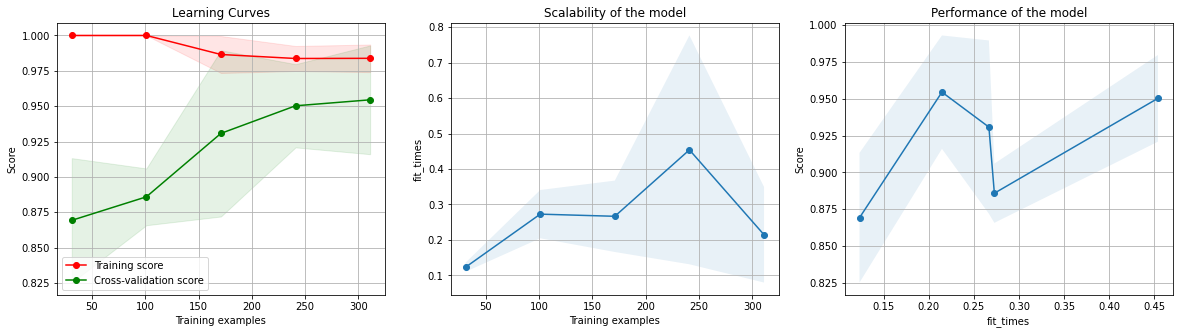

In [ ]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline2_round1, 'Learning Curves',
                    X_train_features, y_train, n_jobs=-1,scoring='f1_macro')

#### <font color='ember'> Check Cross Validation and Train Score

In [ ]:
# let's check the train scores
print(grid_classifier_2.best_estimator_.score(X_train_features, y_train))

# let's check the cross validation score
print(grid_classifier_2.best_score_)

0.9922879177377892
0.9679313418157232


#### <font color='ember'> Evaluate Model on Test Data

In [ ]:
# Final Pipeline
def final_pipeline(text):
    features, feature_names = featurizer.fit_transform(text)
    best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
    predictions = best_estimator_pipeline2_round1.predict(features)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

#### <font color='ember'> Classification report for test dataset

In [ ]:
print('\nTest set classification report:\n\n', 
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.97      0.98      0.98       145
           1       0.86      0.83      0.84        23

    accuracy                           0.96       168
   macro avg       0.92      0.90      0.91       168
weighted avg       0.96      0.96      0.96       168



### <font color='skyblue'>Pipeline 3: Combine Manual Features and TfIDF Vectors

#### <font color='ember'> Combine Manual Features and TFIDF Features

In [ ]:
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)

In [ ]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis =1)

In [ ]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,û r stayin extra week d. rugby weekend hi c u...,29.0,116.0,88.0,2.933333,0.0,0.0,3.0,10.0,1.0,3.0,1.0
1,weekend fine excuse decorate,12.0,60.0,49.0,3.769231,0.0,0.0,1.0,2.0,2.0,1.0,2.0
2,text82228 > > ringtone logo game question,10.0,57.0,48.0,4.363636,5.0,1.0,1.0,5.0,0.0,1.0,1.0
3,week savamob member offer accessible 087095015...,20.0,129.0,110.0,5.238095,19.0,6.0,7.0,12.0,1.0,2.0,1.0
4,auction round 4 high bid å£54 maximum bid å£71...,22.0,105.0,84.0,3.652174,14.0,6.0,3.0,9.0,2.0,3.0,5.0


In [ ]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               389 non-null    object 
 1   count_words                389 non-null    float64
 2   count_characters           389 non-null    float64
 3   count_characters_no_space  389 non-null    float64
 4   avg_word_length            389 non-null    float64
 5   count_digits               389 non-null    float64
 6   count_numbers              389 non-null    float64
 7   noun_count                 389 non-null    float64
 8   aux_count                  389 non-null    float64
 9   verb_count                 389 non-null    float64
 10  adj_count                  389 non-null    float64
 11  ner                        389 non-null    float64
dtypes: float64(11), object(1)
memory usage: 36.6+ KB


In [ ]:
subset = X_train_final[0:10]

In [ ]:
subset.shape

(10, 12)

In [ ]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
''' 
we are testing with the following parameters:
1. max_features: means that only the top 10 most frequent words will be considered
2. n_grams: In this case would mean that both bi-grams and tri-grams will be considered
3. lowercase: We specify that the words should not be changed to lowercase
4. Token Pattern: this pattern matches 2 or more alphanumeric characters bounded by word boundaries
'''
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=10, ngram_range=(2, 3), lowercase=False, token_pattern=r'\b\w\w+\b')), ])

In [ ]:
sparse_features.fit_transform(subset.iloc[:, 1:])

<10x11 sparse matrix of type '<class 'numpy.float64'>'
	with 88 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.fit_transform(subset.iloc[:, 0])

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [ ]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [ ]:
test = combined_features.fit_transform(subset)

In [ ]:
test.dtype

dtype('float64')

#### <font color='ember'> Create Final Pipeline

In [ ]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                        ])

In [ ]:
classifier_3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

#### <font color='ember'> Parameter Grid

In [ ]:
# We are exploring a small combination of parameters
# If the search space is very large then we should use RandomSerachCV or some other methods

param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000, 4000, 8000, 16000], 
                           'classifier__C': [0.01, 0.05, 0.1, 1, 10, 100, 1000, 10000,100000],
                           'classifier__class_weight': [{0:1, 1: cw} for cw in [1,2,10,15,20,25,30]]
                          }

#### <font color='ember'>Specify GridSearch

In [ ]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_3 = RandomizedSearchCV(estimator=classifier_3, 
                                 param_distributions=param_grid_classifier_3,
                                 cv=8, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro')

#### <font color='ember'> Fit the Model

In [ ]:
# Fit the model on training data
grid_classifier_3.fit(X_train_final, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('combined_features',
                                              ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                           SparseTransformer())]),
                                                                transformers=[('tfidf',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer(lowercase=False,
                                                                                                                max_features=10,
                                                                                                                ngram_range=(2,
                                                                                                                 

#### <font color='ember'>Get Best Parameters

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.97

Best parameters:  {'combined_features__tfidf__tfidf__max_features': 16000, 'classifier__class_weight': {0: 1, 1: 10}, 'classifier__C': 1000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(lowercase=False,
                                                                                   max_features=16000,
                                                                                   ngram_range=(2,
                                                                                                3),
                                                                         

#### <font color = 'ember'> Plot Learnning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

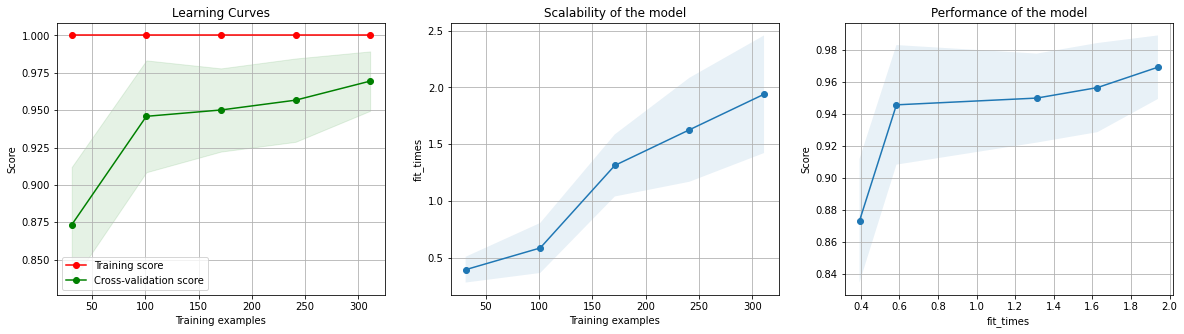

In [ ]:
# plot learning curces
plot_learning_curve(grid_classifier_3.best_estimator_, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1,scoring='f1_macro')

#### <font color = 'ember'> Check Cross Validation Score and Train Score

In [ ]:
# let's check the train scores
print(grid_classifier_3.best_estimator_.score(X_train_final, y_train))

# let's check the cross validation score
print(grid_classifier_3.best_score_)

1.0
0.9676862039166865


#### <font color = 'ember'> Evaluate model on test data

In [ ]:
X_test.shape

(168,)

In [ ]:
# Final Pipeline
def final_pipeline(text):
    X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(X_test_cleaned, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    predictions = grid_classifier_3.best_estimator_.predict(X_final)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

#### <font color='ember'> Classification Report

In [ ]:
print('\nTest set classification report:\n\n', classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.97      0.99      0.98       145
           1       0.90      0.83      0.86        23

    accuracy                           0.96       168
   macro avg       0.94      0.91      0.92       168
weighted avg       0.96      0.96      0.96       168



#### Based on the output of the three models we would choose model 3 as it has the highest f1 score amongst the 3 models and shows to have the highest precision thus reducing the number of false positives and showing a less chance of tagging emails as spam incorrectly. It also has a lower difference between the cross valdiation score and train score thus there seems to be a less chance of overfitting while in the case of model 1 there is a significant difference in cross validation score and train score which is indicative of overfitting 